# Session 2
1. data splitting
2. Train first model
3. A bit about data splitting
4. Model comparision

In [94]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
import math
import statistics
from sklearn.model_selection import cross_val_score

In [68]:
egfr_activities_df = pd.read_csv("../data/EGFR-activities-prepared.csv", index_col=0)
egfr_activities_df.head()

,pIC50,standard_units,molecule_dictionary.chembl_id,canonical_smiles
0,6.339419,nM,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1
1,5.484537,nM,CHEMBL1016,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
2,5.136677,nM,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1
3,6.494850,nM,CHEMBL102726,c1ccc(CNc2ncnc3ccccc23)cc1
4,5.387216,nM,CHEMBL103552,O=C(O)c1cc(N(Cc2ccccc2O)Cc2cc(O)ccc2O)ccc1O


## Featuration

In [69]:
fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=1024) # default radius 3

egfr_activities_df['morgan_fp'] = egfr_activities_df['canonical_smiles'].apply(lambda smiles : fpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles)))
egfr_activities_df.head()

,pIC50,standard_units,molecule_dictionary.chembl_id,canonical_smiles,morgan_fp
0,6.339419,nM,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5.484537,nM,CHEMBL1016,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5.136677,nM,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6.494850,nM,CHEMBL102726,c1ccc(CNc2ncnc3ccccc23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5.387216,nM,CHEMBL103552,O=C(O)c1cc(N(Cc2ccccc2O)Cc2cc(O)ccc2O)ccc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [70]:
X = np.stack(egfr_activities_df['morgan_fp'])
y = np.array(egfr_activities_df['pIC50'])

## Random data split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
print(f"Dimentions of training input: {X_train.shape}")
print(f"Dimentions of training output: {y_train.shape}")
print(f"Dimentions of training input: {X_test.shape}")
print(f"Dimentions of training output: {y_test.shape}")

Dimentions of training input: (5358, 1024)
Dimentions of training output: (5358,)
Dimentions of training input: (1340, 1024)
Dimentions of training output: (1340,)


## Random forest regression

In [73]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [74]:
y_pred_train = rf_model.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
r_square_train = r2_score(y_train, y_pred_train)
print(f"Train (MSE): {mse_train}")
print(f"Train (R^2): {r_square_train}")

Train (MSE): 0.09156707646344872
Train (R^2): 0.9564770804566474


In [75]:
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print(f"Test (MSE): {mse}")
print(f"Test (R^2): {r_square}")

Test (MSE): 0.6564187034112835
Test (R^2): 0.6710319339224109


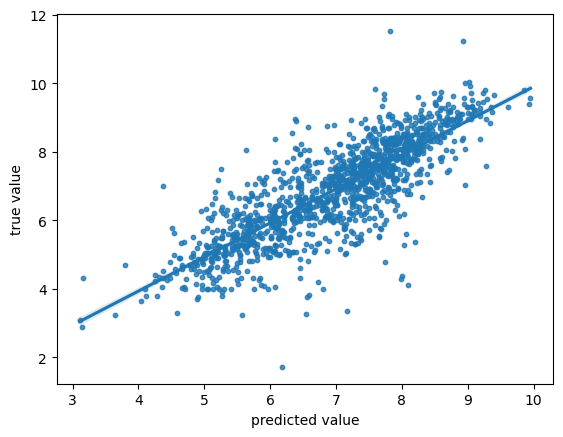

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.scatter(y_pred, y_test, marker='.')
sns.regplot(x = y_pred, y = y_test, scatter_kws={'s':10})
plt.ylabel('true value')
plt.xlabel('predicted value')
plt.show()

Top 3 bits: [428 128 621]


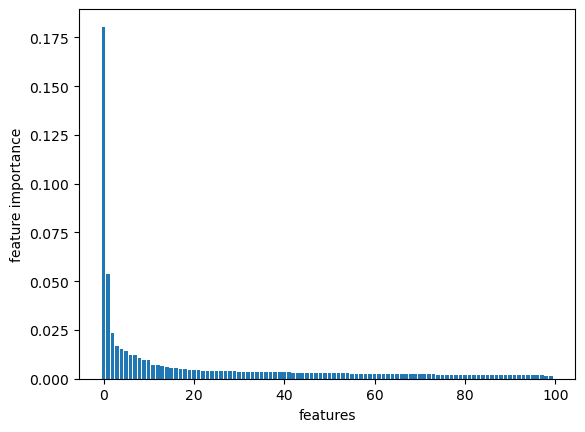

In [77]:
plt.bar(range(100), sorted(rf_model.feature_importances_, reverse=True)[:100])
plt.ylabel('feature importance')
plt.xlabel('features')
top3bits = np.argsort(rf_model.feature_importances_)[:-4:-1]
print(f"Top 3 bits: {top3bits}")

## Cluster-based Split (?)

##  Model comparison

CV with random split?

Validation set

In [78]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

10-fold CV

In [83]:
kf = KFold(n_splits=5)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_test_scores = {"MSE": [], "R2": []}

for split, (train_idx, val_idx) in enumerate(kf.split(X_cv, y_cv)):
    X_train, y_train = X_cv[train_idx], y_cv[train_idx]
    X_val, y_val = X_cv[val_idx], y_cv[val_idx]
    
    rf_model.fit(X_train, y_train)
    rf_model.predict(X)
    
    y_pred = rf_model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    r_square = r2_score(y_val, y_pred)
    
    print(f"Split {split}:\n\tMSE={mse}\n\tR^2={r_square}")
    
    rf_cv_test_scores["MSE"].append(mse)
    rf_cv_test_scores["R2"].append(mse)

Split 0:
	MSE=0.6391358367281814
	R^2=0.6717535195086208
Split 1:
	MSE=0.5759685552875256
	R^2=0.7343841153971666
Split 2:
	MSE=0.6023956520987523
	R^2=0.7055028793061981
Split 3:
	MSE=0.6116147206528161
	R^2=0.7140100738603347
Split 4:
	MSE=0.6277859853674681
	R^2=0.7000079846743568


In [89]:
print(f"Mean validation MSE: {statistics.mean(rf_cv_test_scores['MSE']):.2f}±{statistics.stdev(rf_cv_test_scores['MSE']):.2f}")

Mean validation MSE: 0.61±0.02


In [92]:
ridge = Ridge(solver = "svd")
ridge_mse_cv = cross_val_score(ridge, X_cv, y_cv, scoring='neg_mean_squared_error')
print(f"Mean validation MSE: {-ridge_mse_cv.mean():.2f}±{ridge_mse_cv.std():.2f}")

Mean validation MSE: 0.94±0.04


## Classification (?)

## Excercises

### Excerise 1 (Hyperparameter tuning -> naiv)

In [ ]:
# Can the CV MSE of the RF be improved by changing the number of trees? Try different numbers here
# TODO

In [ ]:
# Do the same for Ridge

### Exercise 2 (Hyperparameter tuning -> Grid Search)

### Excerise 3 (Classification)

In [ ]:
# generate labels from pIC50, if > x => active (1), else inactive (0)
# TODO

In [ ]:
# train a RF, use f1_score as metric

In [ ]:
# in lecture learned SVM, train a SVM. Is it's performance superior to RF?